## 1. Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.9 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=d212574371debd0b8f8dcc265f470d027af821737330a40cd894b869248b6951
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

import nltk

# It helps to remove the accented characters
import unidecode

from nltk.tokenize import word_tokenize,sent_tokenize,regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re,string,unicodedata
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup

# It help to correct the spellings
from autocorrect import Speller

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

# 2. Data Extraction and Cleaning

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thought classification/data_thought_new.csv')

In [ ]:
data.head()

,Thought,Label
0,Everyone is probably mad at me,negative
1,You're braver than you believe,positive
2,"When I open my eyes, you're all that I want to...",positive
3,They clearly don’t want to be friends with me ...,negative
4,I've never done it before.,negative


In [ ]:
data.tail()

,Thought,Label
156781,I can't eat spicy food.,negative
156782,Itâ€™s OK to SCREW Up! Nigel Raw,positive
156783,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive
156784,Stuck On You â€“ Coverrrrr by Alicia Widar,negative
156785,No words for this ðŸ¤¨,negative


In [ ]:
## Assess the shape of the data
print("The Shape of the Dataset",data.shape)

The Shape of the Dataset (156786, 2)


In [ ]:
data.describe()

,Thought,Label
count,156785,156785
unique,129051,2
top,Help,positive
freq,65,85677


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156786 entries, 0 to 156785
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Thought  156785 non-null  object
 1   Label    156785 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [ ]:
data['Label'].unique()

array(['negative', 'positive', nan], dtype=object)

In [ ]:
print(data['Label'].value_counts())

positive    85677
negative    71108
Name: Label, dtype: int64


In [ ]:
null_values = data.isnull().sum()  #check null values
print(null_values)

Thought    1
Label      1
dtype: int64


In [ ]:
data = data.dropna(how='any',axis=0) #drop null values

In [ ]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate thought present in the dataset'.format(num_duplicates))

There are 27705 duplicate thought present in the dataset


In [ ]:
#view duplicate thoughts
thought = data['Thought']
duplicated_thought = data[thought.isin(thought[thought.duplicated()])].sort_values("Thought")


In [ ]:
#drop duplicate thoughts
data.drop_duplicates(inplace = True)

In [ ]:
#reseting the index of data frame since some rows have been deleted
data.reset_index(drop=True, inplace=True)

In [ ]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 129080 rows and 2 columns after removing duplicates


In [ ]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
print(wl)

<WordNetLemmatizer>


In [ ]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "can not",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

## Text Preprocessing

### Remove accented characters

In [ ]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):

    t = data['Thought'][i].split()
    # Applying the unicode data on a sentence and replacing the accented words to get the closest possible ASCII text
    new_text = [unidecode.unidecode(word) for word in t]

    # Combining the seperate words into sentence
    new_text = ' '.join(new_text)
    # append the new_text to list text
    text.append(new_text)

data['cleaned_text'] = text

### Removing Special Characters

In [ ]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    words = data['cleaned_text'][i].split() # splitting text into separate words
    new_text = ' '.join([element for element in words if element.isalnum()]) # looping over each element of the list and using the join() function to retrive the original text
    text.append(new_text)  # append the new_text to empty list text

data['cleaned_text'] = text

### Lowercasing

In [ ]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # lowecasing the text using the lower() function
    new_text = data['cleaned_text'][i].lower()
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text

In [ ]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my all that i want to see
3,They clearly don’t want to be friends with me ...,negative,they clearly want to be friends with me anymore
4,I've never done it before.,negative,never done it


In [ ]:
data.tail()

,Thought,Label,cleaned_text
129075,I can't wait to go on vacation next month.,negative,i wait to go on vacation next
129076,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw nigel raw
129077,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,it fits right
129078,Stuck On You â€“ Coverrrrr by Alicia Widar,negative,stuck on you coverrrrr by alicia widar
129079,No words for this ðŸ¤¨,negative,no words for this


### Spellchecking

In [ ]:
"""
# intializing the spellchecker and setting the language to english
spell = Speller(lang = 'en')

# defining a function which will take text as an input break
def autospell(text):
    '''
    A function which takes text as an input, performs a spell check, and autocorrects misspelled words
    text: text input (object)
    '''
    word = text.split() # splitting text into separate words
    spells = [spell(w) for w in word] # Spell checking on each word
    return " ".join(spells) # retriving the original text
"""

In [ ]:
"""
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # applying the autospell function on the text messages
    new_text = autospell(data['cleaned_text'][i])
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text
"""

"\n# defining an empty list\ntext = []\n\n# looping over each message in the data\nfor i in range(data.shape[0]):\n    # applying the autospell function on the text messages\n    new_text = autospell(data['cleaned_text'][i])\n    text.append(new_text) # append the new_text to empty list text\n\ndata['cleaned_text'] = text\n"

In [ ]:
data.tail()

,Thought,Label,cleaned_text
129075,I can't wait to go on vacation next month.,negative,i wait to go on vacation next
129076,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw nigel raw
129077,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,it fits right
129078,Stuck On You â€“ Coverrrrr by Alicia Widar,negative,stuck on you coverrrrr by alicia widar
129079,No words for this ðŸ¤¨,negative,no words for this


In [ ]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my all that i want to see
3,They clearly don’t want to be friends with me ...,negative,they clearly want to be friends with me anymore
4,I've never done it before.,negative,never done it


In [ ]:
# Remove all the special characters
def remove_special_char(text):
    return re.sub('[^A-Za-z0-9]+', ' ', text)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#expanding chatwords and contracts clearing contractions
def expanding_chatwords(text):
    return ' '.join([mapping[t] if t in mapping else t for t in text.lower().split(" ")])

#emoli clean
def clean_emoji(text):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_clean.sub(r'',text)

# remove all single characters
def remove_single_char(text):
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

# Remove single characters from the start
def remove_single_char_from_start(text):
    return re.sub(r'\^[a-zA-Z]\s+', ' ', text)

# Substituting multiple spaces with single space
def Sub_multiple_space(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#add space after full stop
def space_after_fullstop(text):
    return re.sub(r'\.(?=\S)', '. ',text)

# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

#removing punctuation
def remove_punctuation(text):
    return "".join([word.lower() for word in text if word not in string.punctuation])

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def tokenization(text):
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop]  #Removing stop words
    return " ".join(filtered_text)


#lemmatize
def lemmatization(text, lemmatize= True):
    if lemmatize:
        return " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])
    else:
        return " ".join([word for word in text.split() if word not in stop and word.isalpha()])

#Removing the noisy text
def clean_text(text):

    #text = remove_special_char(text)
    text = strip_html(text)
    text = expanding_chatwords(text)
    text = remove_between_square_brackets(text)
    text = clean_emoji(text)
    text = remove_URL(text)
    text = space_after_fullstop(text)
    text = remove_single_char(text)
    text = remove_single_char_from_start(text)
    text = Sub_multiple_space(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = tokenization(text)
    text = lemmatization(text, lemmatize= True)


    return text

In [ ]:
data_copy = data.copy()

In [ ]:
#data['Thought_clean']=data['Thought'].apply(clean_text,lemmatize = True)
data['Thought_clean']=data['cleaned_text'].apply(clean_text)

In [ ]:
data.head()

,Thought,Label,cleaned_text,Thought_clean
0,Everyone is probably mad at me,negative,everyone is probably mad at me,everyone probably mad
1,You're braver than you believe,positive,braver than you believe,braver believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my all that i want to see,open want see
3,They clearly don’t want to be friends with me ...,negative,they clearly want to be friends with me anymore,clearly want friend anymore
4,I've never done it before.,negative,never done it,never done


In [ ]:
data.tail()

,Thought,Label,cleaned_text,Thought_clean
129075,I can't wait to go on vacation next month.,negative,i wait to go on vacation next,wait go vacation next
129076,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw nigel raw,ok screw nigel raw
129077,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,it fits right,fit right
129078,Stuck On You â€“ Coverrrrr by Alicia Widar,negative,stuck on you coverrrrr by alicia widar,stuck coverrrrr alicia widar
129079,No words for this ðŸ¤¨,negative,no words for this,word


## 3. Exploratory data analysis

In [ ]:
print(data['Label'].value_counts())

positive    71185
negative    57895
Name: Label, dtype: int64


In [ ]:
print('Positive thoughts are', (round(data['Label'].value_counts()[0])),'i.e.', round(data['Label'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative thoughts are', (round(data['Label'].value_counts()[1])),'i.e.',round(data['Label'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive thoughts are 71185 i.e. 55.15 % of the dataset
Negative thoughts are 57895 i.e. 44.85 % of the dataset


Text(0.5, 1.0, 'Thought Distribution')

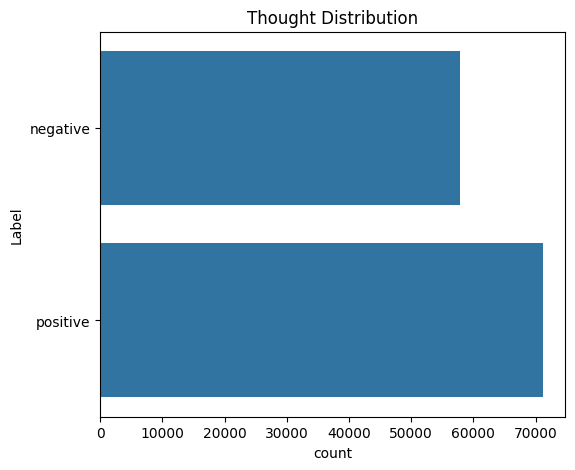

In [ ]:
plt.figure(figsize =(6,5))
sns.countplot(data['Label'])
plt.title("Thought Distribution")

In [ ]:
#converting target variable to numeric labels
data.Label = [ 1 if each == "positive" else 0 for each in data.Label]

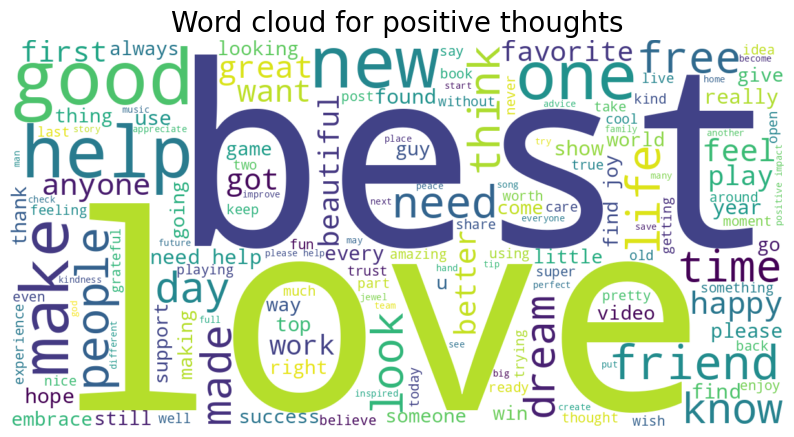

In [ ]:
#word cloud for positive thought
positive_data = data[data.Label == 1].Thought_clean
positive_data_string = " ".join(positive_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 150, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive thoughts',fontsize = 20)
plt.show()

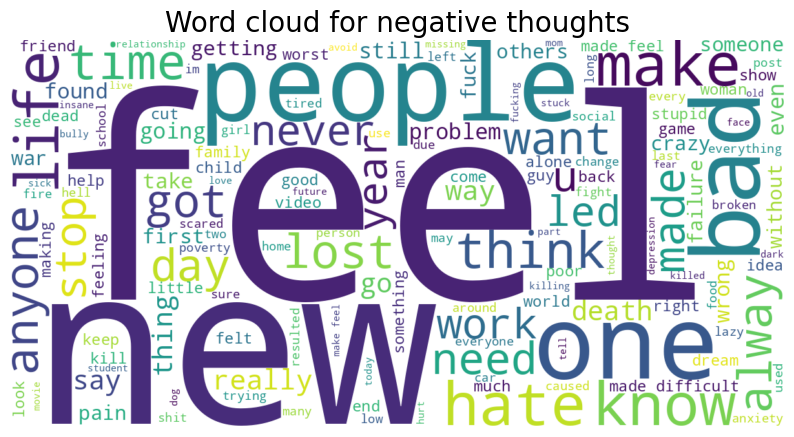

In [ ]:
#word cloud for negative thought
negative_data = data[data.Label == 0].Thought_clean
negative_data_string = " ".join(negative_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 150, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative thoughts',fontsize = 20)
plt.show()

## 4. Feature Extraction

In [ ]:
def extracting_len_of_thought (data,col_name):
   w = data[col_name].apply(lambda x :x.lower())
   len_of_thought = [len(word_tokenize(i)) for i in w]
   return len_of_thought

In [ ]:
data['n_of_words'] = extracting_len_of_thought(data,'Thought')
data.head()

,Thought,Label,cleaned_text,Thought_clean,n_of_words
0,Everyone is probably mad at me,0,everyone is probably mad at me,everyone probably mad,6
1,You're braver than you believe,1,braver than you believe,braver believe,6
2,"When I open my eyes, you're all that I want to...",1,when i open my all that i want to see,open want see,14
3,They clearly don’t want to be friends with me ...,0,they clearly want to be friends with me anymore,clearly want friend anymore,12
4,I've never done it before.,0,never done it,never done,7


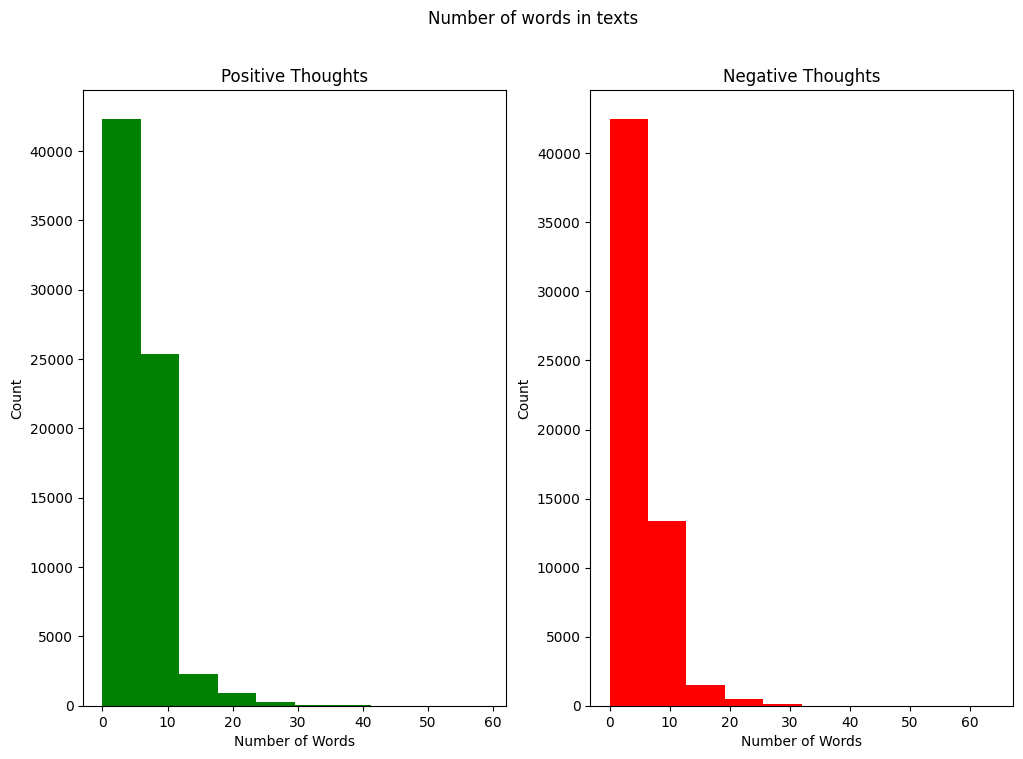

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Thoughts')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Thoughts')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

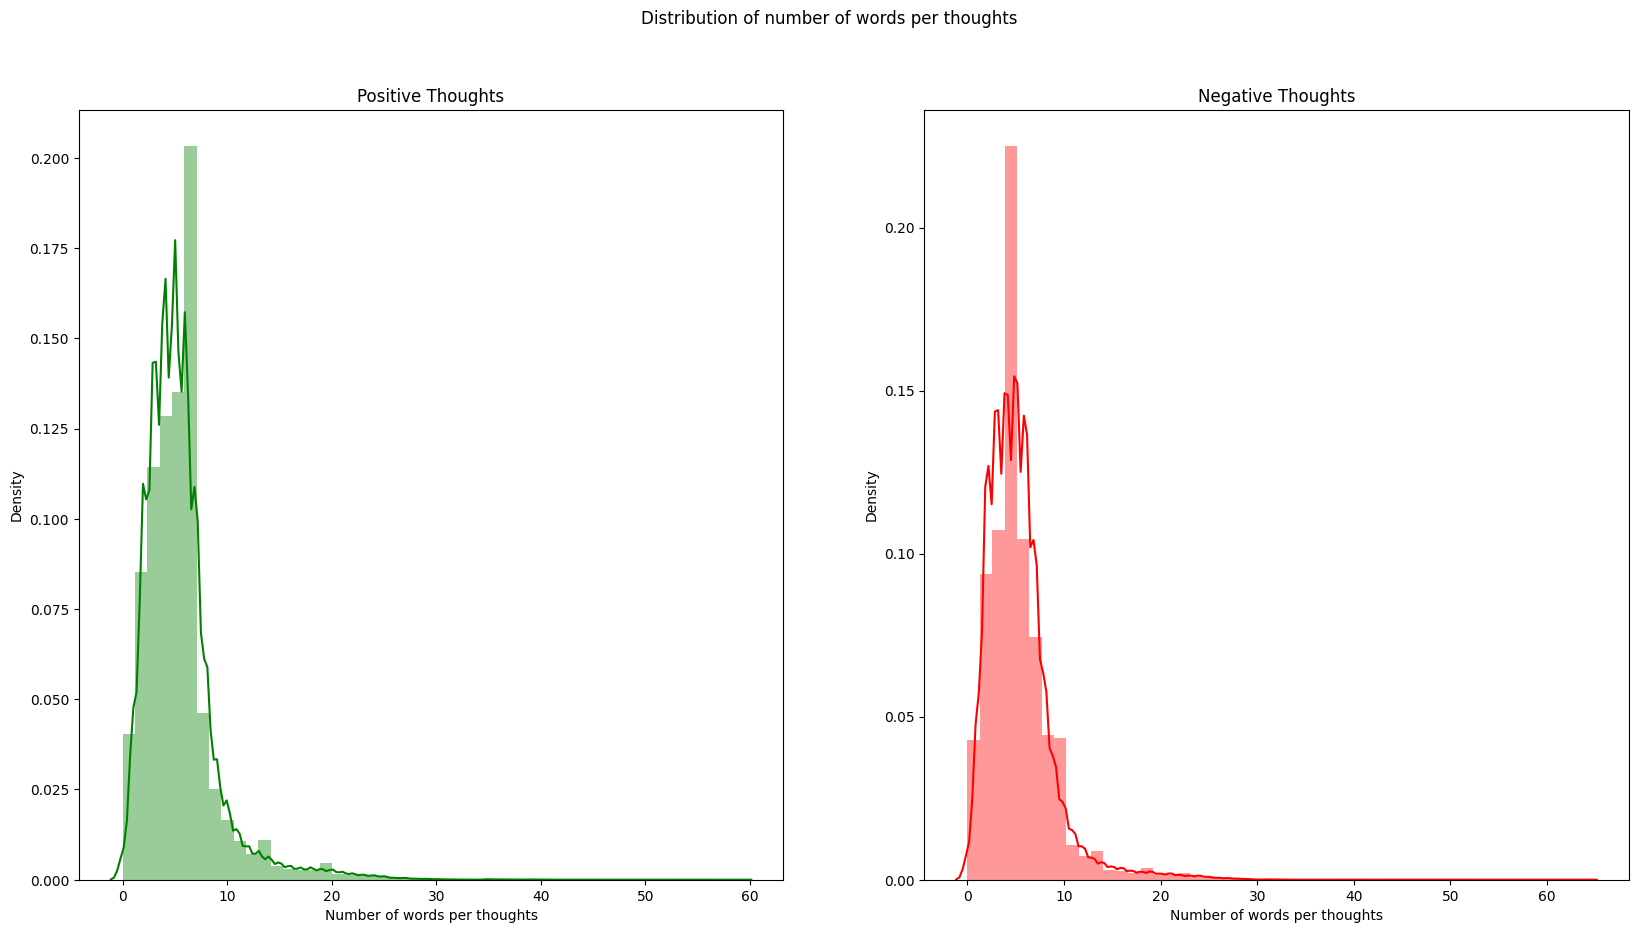

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Thoughts')
ax1.set_xlabel('Number of words per thoughts')
ax1.set_ylabel('Density')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Thoughts')
ax2.set_xlabel('Number of words per thoughts')
ax2.set_ylabel('Density')
fig.suptitle('Distribution of number of words per thoughts')
plt.show()

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.Thought_clean)
corpus[:10]

['everyone',
 'probably',
 'mad',
 'braver',
 'believe',
 'open',
 'want',
 'see',
 'clearly',
 'want']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
print(most_common)

   corpus  countv
0    like    5019
1    help    3565
2    make    3473
3     new    3303
4    feel    3227
5    made    3130
6    find    2482
7    need    2366
8  people    2362
9     get    2356


In [ ]:
most_common = most_common.sort_values('countv')

In [ ]:
plt.rcParams["font.size"] = 12

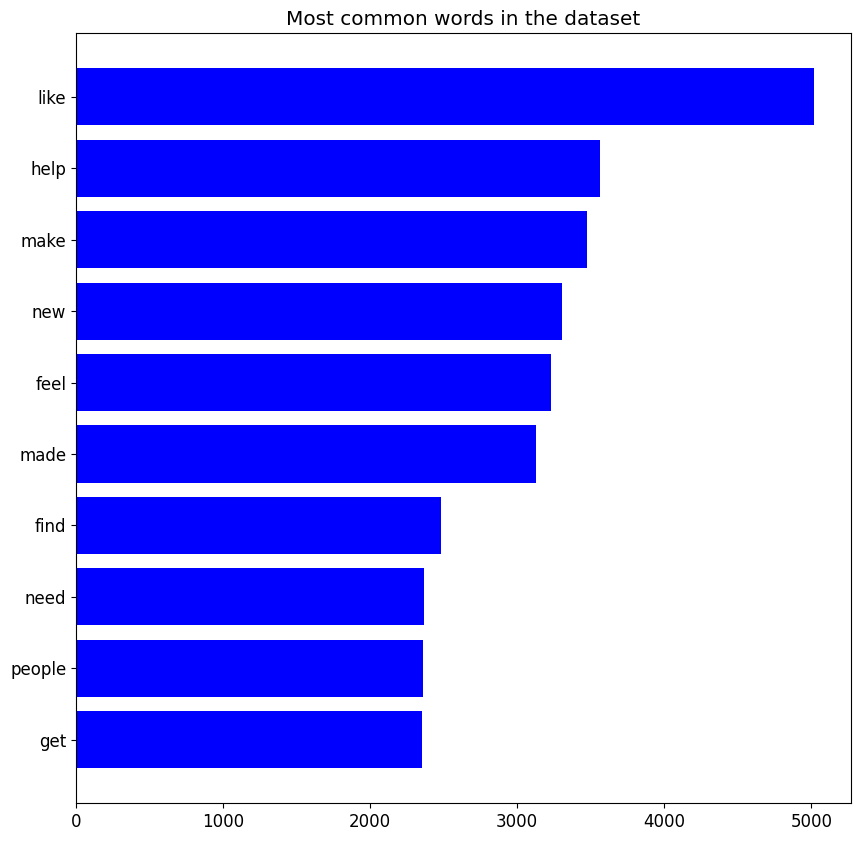

In [ ]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [ ]:
def get_ngrams(Thought_clean, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(Thought_clean)
    bag_of_words = vec.transform(Thought_clean) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency
    return words_freq[:n]

In [ ]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.10, subplot_titles=('Positive Thoughts','Negative Thoughts'))
fig.update_layout(title="Unigram analysis for positive and negative thoughts")
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Positive Thoughts', orientation='h',
             width=600, height=600,color='Common_words')
fig.show()
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Negative Thoughts',orientation='h',
             width=600, height=600,color='Common_words')

fig.show()

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

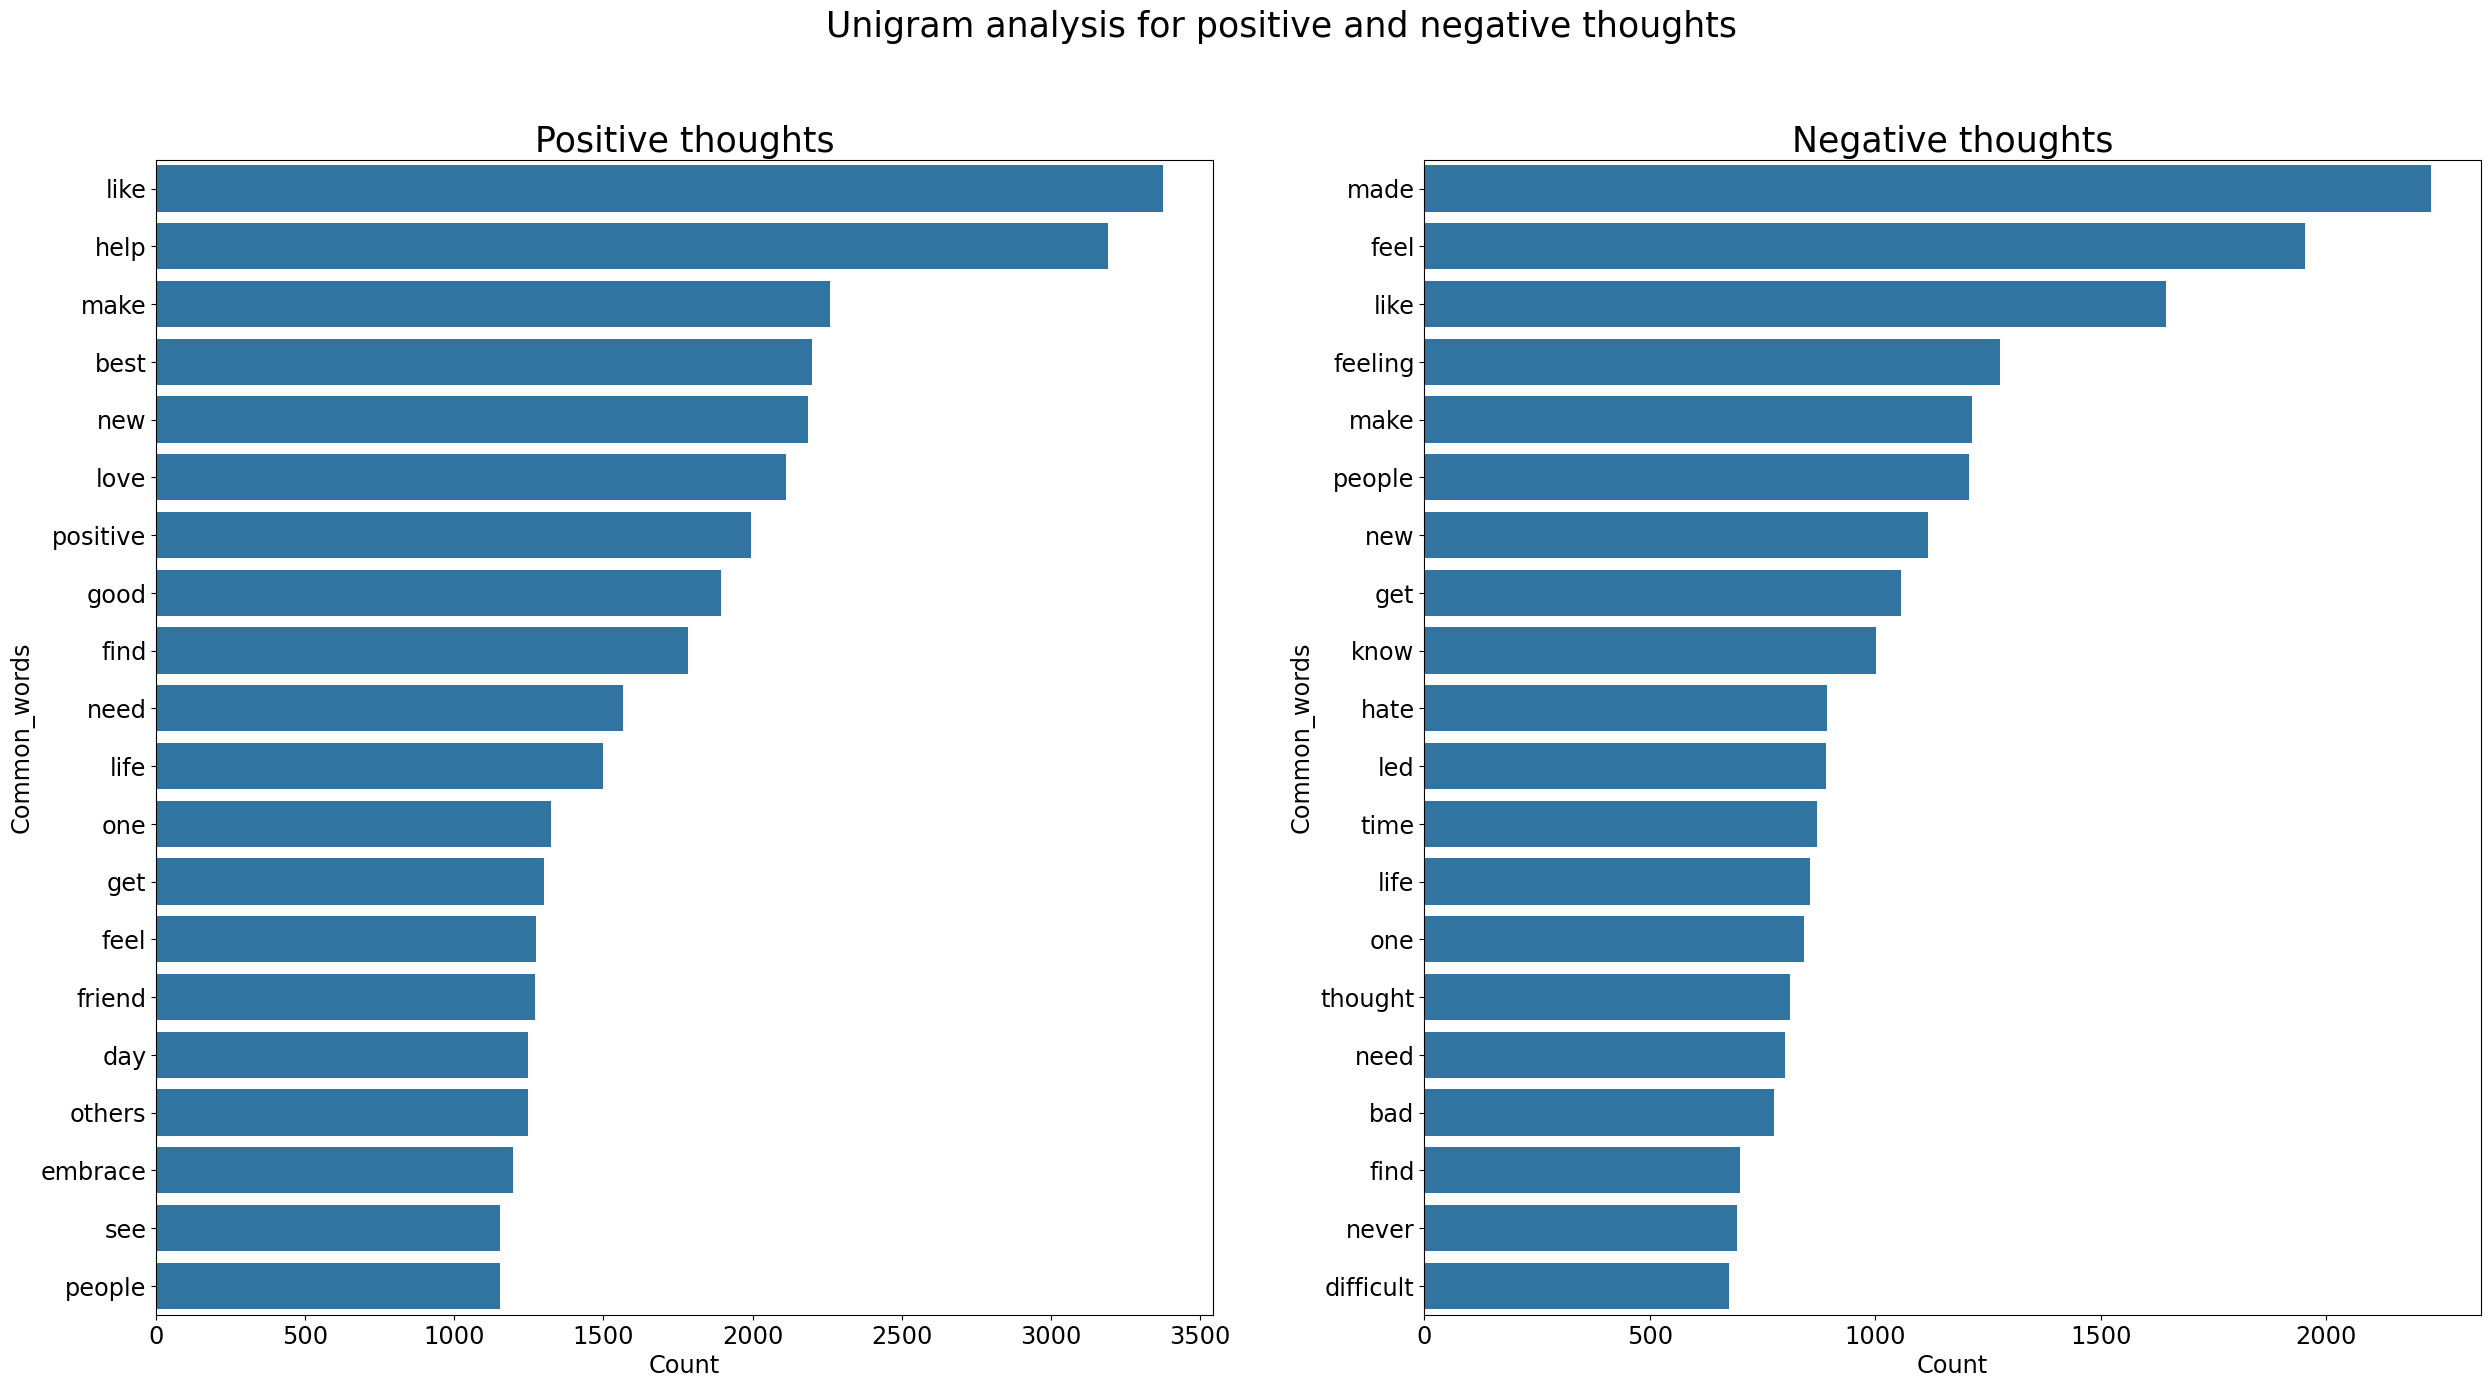

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive thoughts', fontsize=25)
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative thoughts', fontsize=25)
fig.suptitle('Unigram analysis for positive and negative thoughts', fontsize=25)
plt.show()

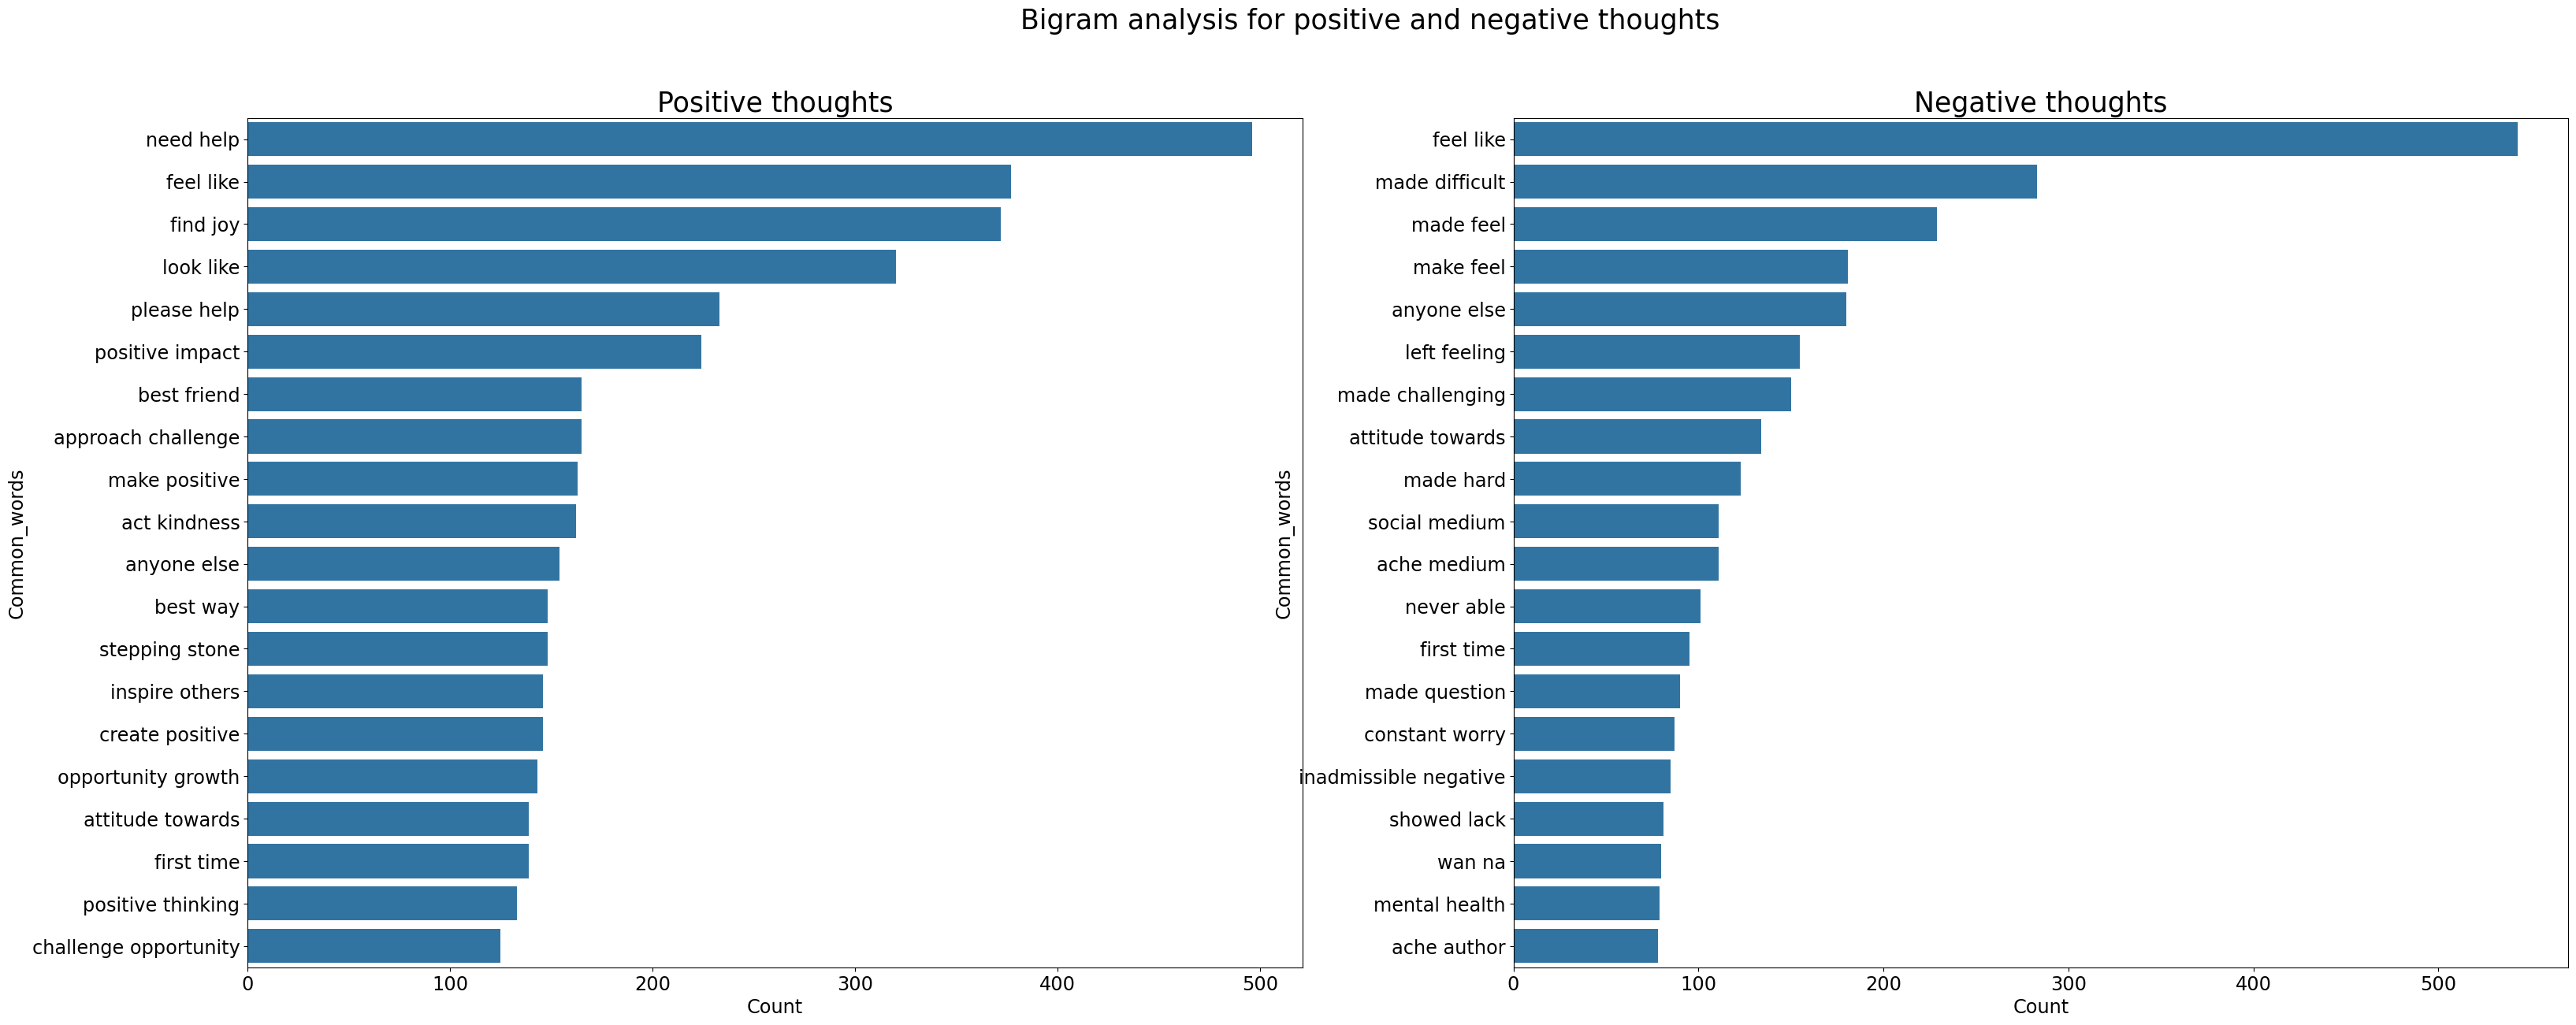

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(38,14))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive thoughts', fontsize=25)
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])

sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative thoughts', fontsize=25)
fig.suptitle('Bigram analysis for positive and negative thoughts', fontsize=25)
plt.show()

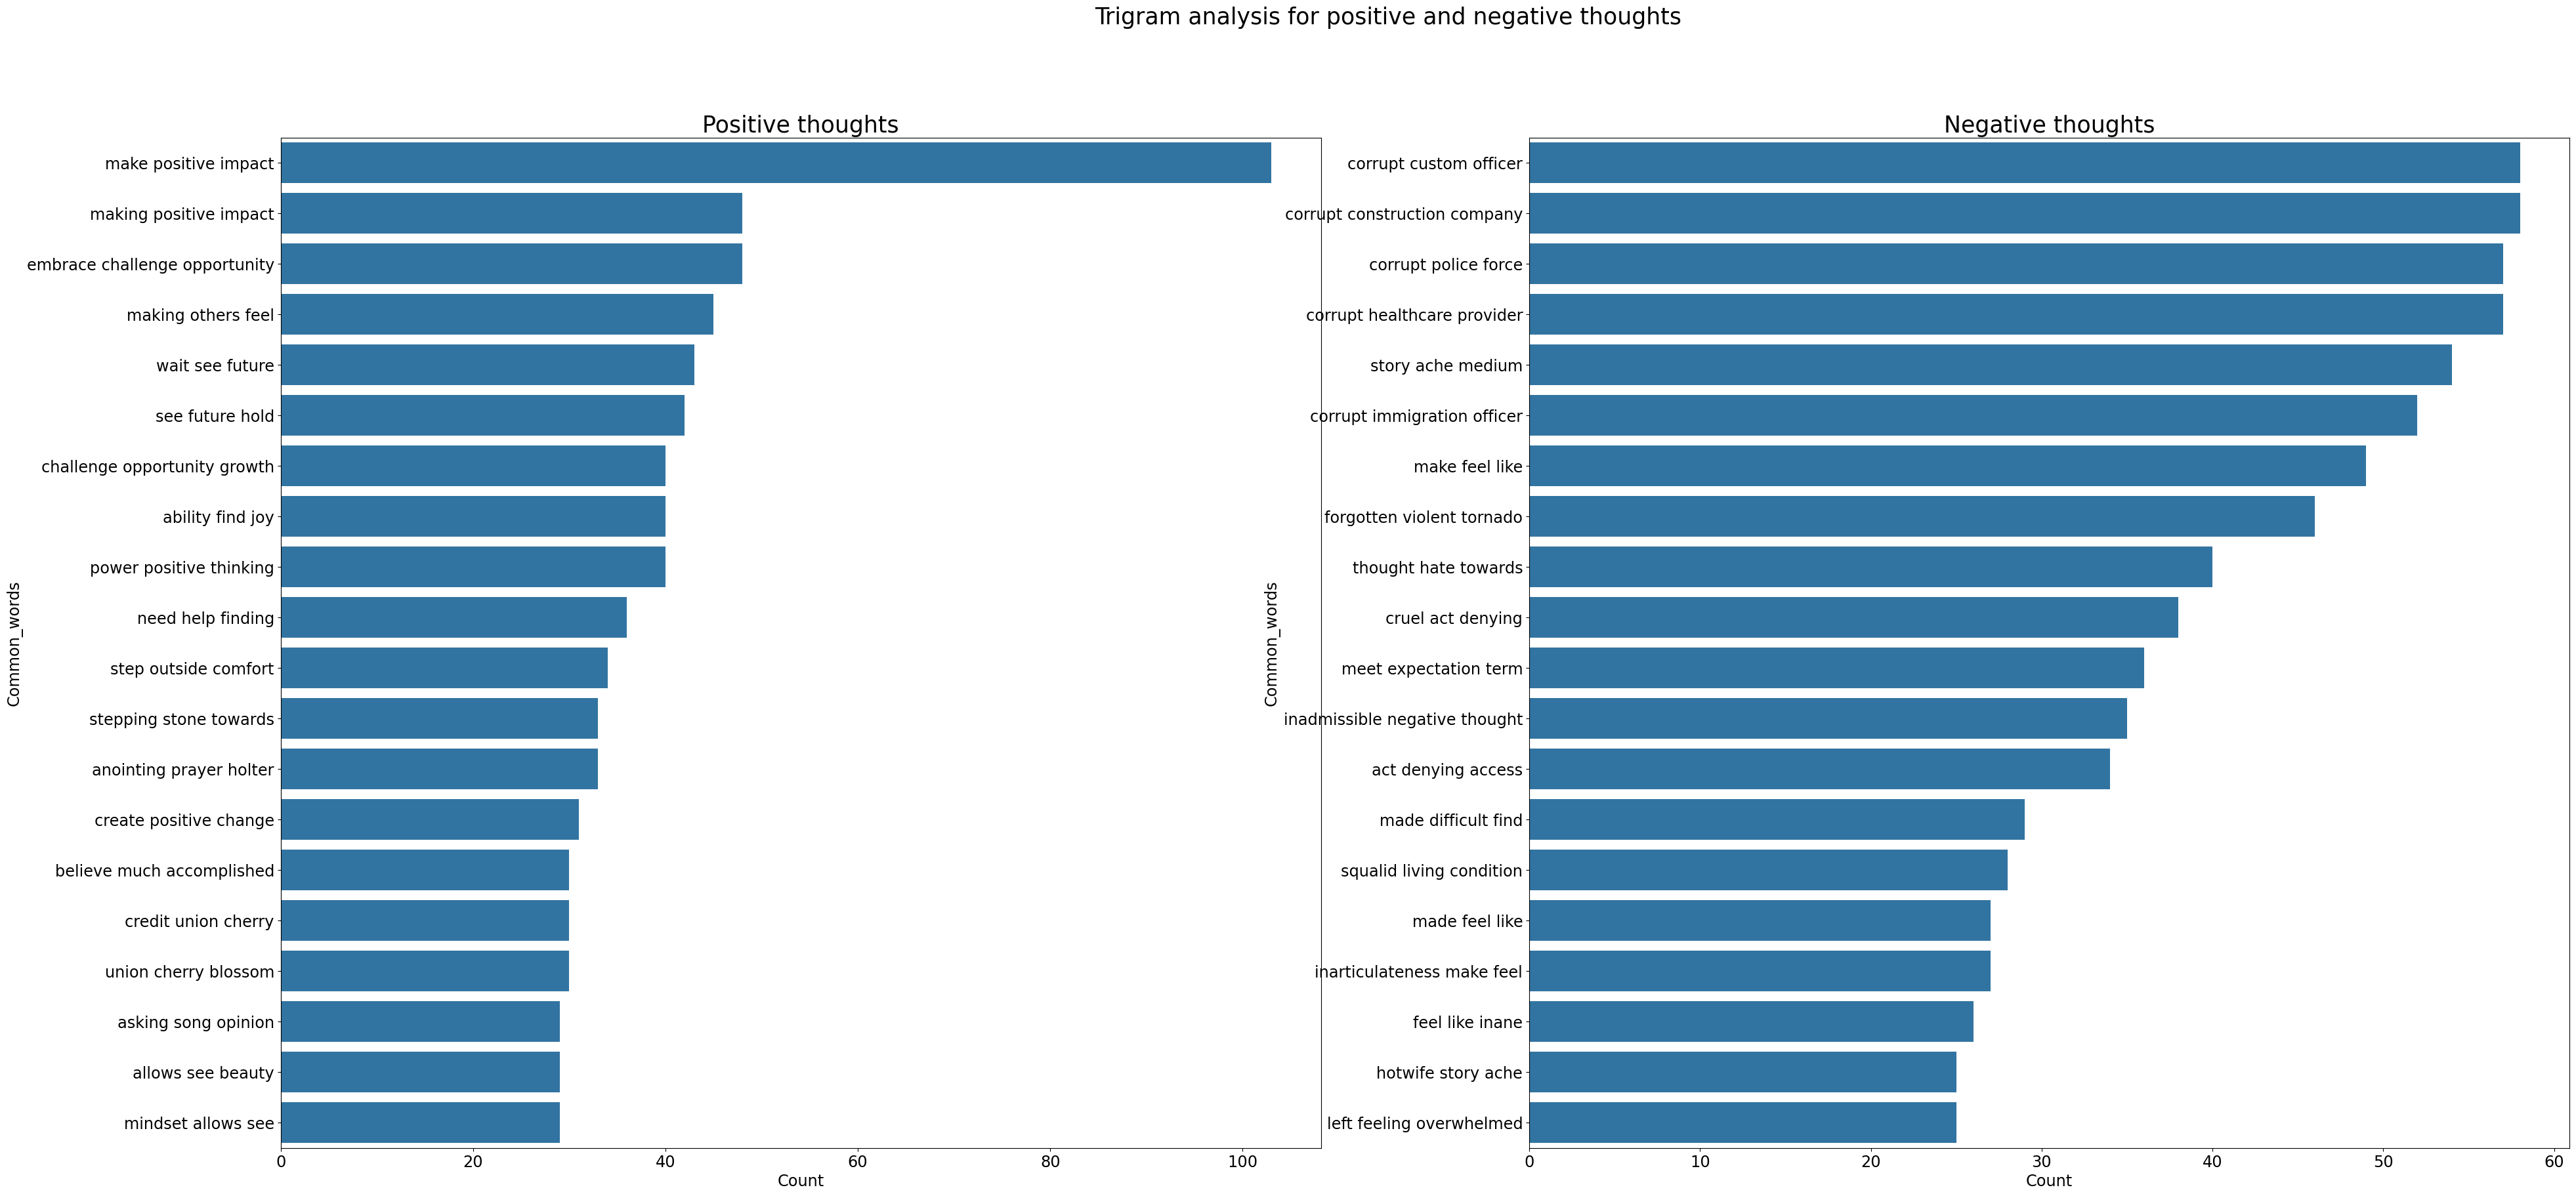

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(45,20))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive thoughts', fontsize=25)
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative thoughts', fontsize=25)
fig.suptitle('Trigram analysis for positive and negative thoughts', fontsize=25)
plt.show()

## 5. Modelling using Machine Learning

### splitting into train and test

In [ ]:
#x_train,x_test,y_train,y_test = train_test_split(data.Thought_clean,data.Label,random_state = 0 , stratify = data.Thought_clean)
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['Thought_clean'], train['Label']
Xtest, ytest = test['Thought_clean'], test['Label']

### Vectorizing data

#### Term Frequency-Inverse Document Frequency model (TFIDF)
It is used to convert text documents to matrix of tfidf features.

In [ ]:
tfidf_vect = TfidfVectorizer()
#transformed train text
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
#transformed test text
Xtest_tfidf = tfidf_vect.transform(Xtest)
print('TFIDF_train:',Xtrain_tfidf.shape)
print('TFIDF_test:',Xtest_tfidf.shape)

TFIDF_train: (103264, 31036)
TFIDF_test: (25816, 31036)


#### Count Vectorizer
It is used to convert text documents to numerical vectors or bag of words.

In [ ]:
#Count vectorizer for bag of words
count_vect = CountVectorizer()
#transformed train text
Xtrain_count = count_vect.fit_transform(Xtrain)
#transformed test text
Xtest_count = count_vect.transform(Xtest)
print('BOW_cv_train:',Xtrain_count.shape)
print('BOW_cv_test:',Xtest_count.shape)

BOW_cv_train: (103264, 31036)
BOW_cv_test: (25816, 31036)


### Modeling

In [ ]:
# Set the default text font size
plt.rc('font', size=12)
# Set the axes title font size
plt.rc('axes', titlesize=12)
# Set the axes labels font size
plt.rc('axes', labelsize=12)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=10)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=10)
# Set the legend font size
plt.rc('legend', fontsize=12)
# Set the font size of the figure title
plt.rc('figure', titlesize=12)

In [ ]:
def testing_various_clf (Xtrain,Xtest,ytrain,ytest):

    models = [("LR",LogisticRegression()),
              ("DT",DecisionTreeClassifier()),
              ("MNB",MultinomialNB()),
              ("RF",RandomForestClassifier()),
              ("XGBoost",XGBClassifier()),
              ("SGD",SGDClassifier())]
    model_accuracy = []
    model_name=[]
    for name, model in models:
        print(f"{'-'*88}\n{name}\n{'-'*88}")
        ypred = model.fit(Xtrain,ytrain).predict(Xtest)
        s=accuracy_score(ytest,ypred)
        print(name,"Classifier Accuracy :", "{:.2f}%".format(100*s))
        print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

        fig, ax = plt.subplots(figsize=(5, 5))
        cm = confusion_matrix(ytest, ypred)
        accuracy = np.trace(cm) / np.sum(cm).astype('float')
        misclass = 1 - accuracy
        model_accuracy.append(100*accuracy)
        model_name.append(name)
        #ConfusionMatrixDisplay.from_estimator(model, Xtest, ytest, cmap=plt.cm.Blues, display_labels=['Negative','Positive'], ax=ax, values_format="d")
        sns.heatmap(cm/np.sum(cm),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
        plt.title('Confusion matrix of the {}'.format(name))
        plt.ylabel('True label')
        plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(100*accuracy, misclass))
        plt.grid(False)

    print("Accuracy of the models ", model_accuracy)
    df = pd.DataFrame(list(zip(model_name, model_accuracy)), columns=['Model', 'Accuracy'])
    plt.figure(figsize = (6,4,)) #set the figure size
    plt.autoscale()
    palette=sns.color_palette("hls", 8)
    plots=sns.barplot(data = df, x = "Model", y="Accuracy", palette=palette)
    sns.despine()
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.2f'),
                        (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=10, xytext=(0, 7),
                        textcoords='offset points')

    plt.xticks(rotation=45)
    plt.show()



###### Result Analysis on count vectorized data

Performance analysis on Count vectorized data:
----------------------------------------------------------------------------------------
LR
----------------------------------------------------------------------------------------
LR Classifier Accuracy : 90.77%
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.90     11624
    Negative       0.91      0.92      0.92     14192

    accuracy                           0.91     25816
   macro avg       0.91      0.91      0.91     25816
weighted avg       0.91      0.91      0.91     25816

----------------------------------------------------------------------------------------
DT
----------------------------------------------------------------------------------------
DT Classifier Accuracy : 84.96%
              precision    recall  f1-score   support

    Positive       0.85      0.80      0.83     11624
    Negative       0.85      0.89      0.87     14192

    accuracy                        

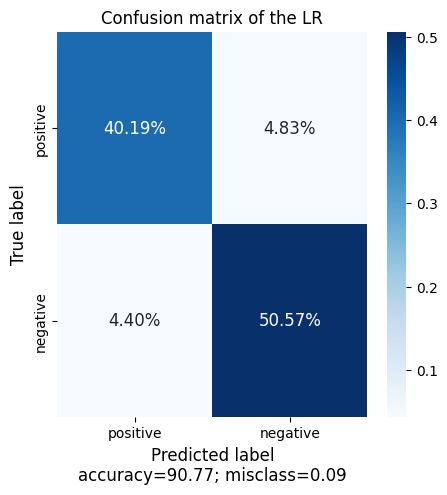

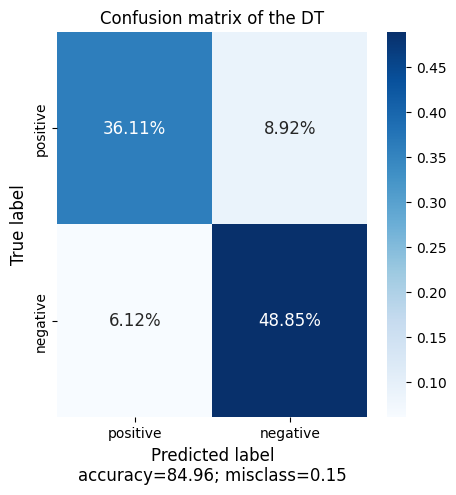

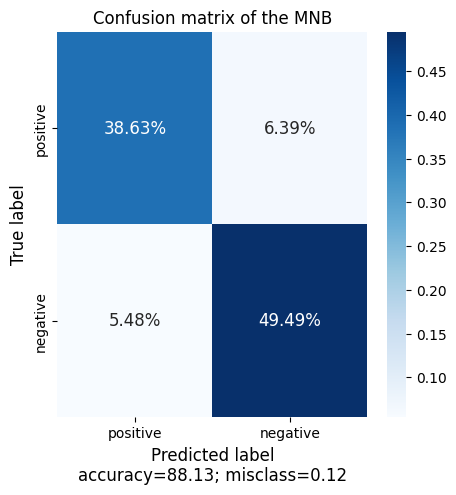

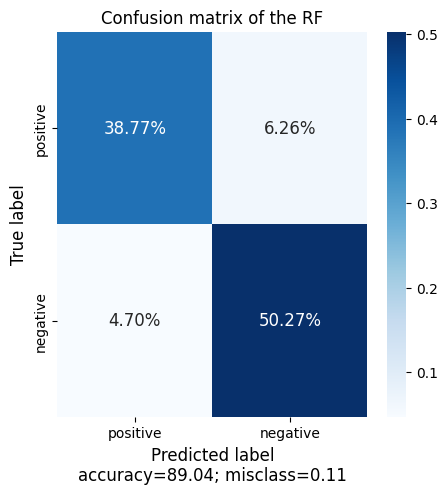

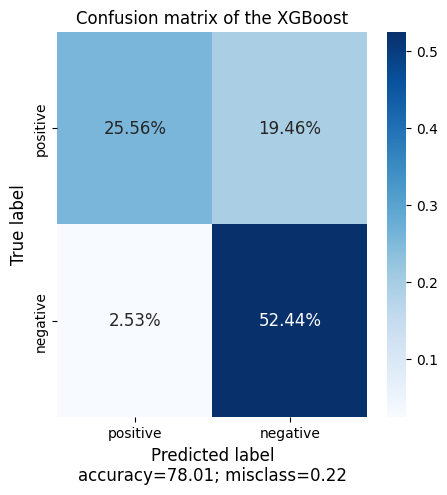

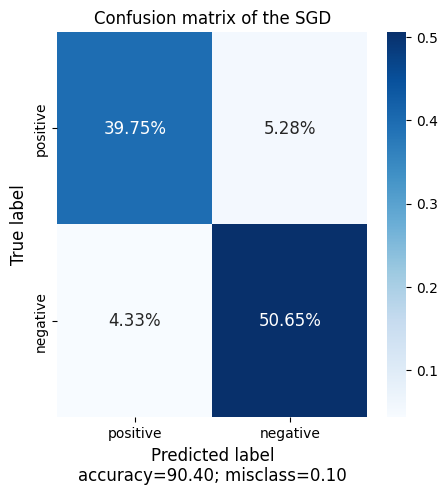

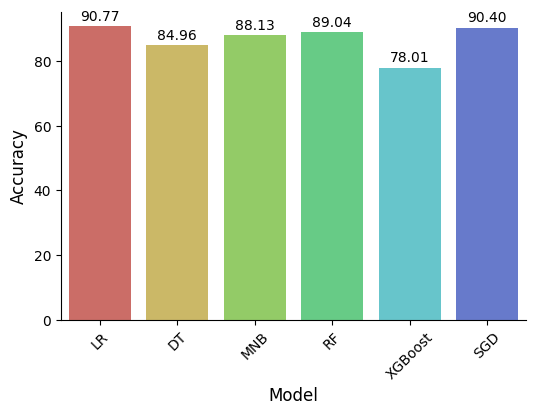

In [ ]:
print("Performance analysis on Count vectorized data:")
testing_various_clf(Xtrain_count,Xtest_count,ytrain,ytest)

###### Result Analysis on tf-idf vectorized data

Performance analysis on Tf-IDF vectorized data:
----------------------------------------------------------------------------------------
LR
----------------------------------------------------------------------------------------
LR Classifier Accuracy : 90.37%
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89     11624
    Negative       0.91      0.92      0.91     14192

    accuracy                           0.90     25816
   macro avg       0.90      0.90      0.90     25816
weighted avg       0.90      0.90      0.90     25816

----------------------------------------------------------------------------------------
DT
----------------------------------------------------------------------------------------
DT Classifier Accuracy : 85.52%
              precision    recall  f1-score   support

    Positive       0.86      0.81      0.83     11624
    Negative       0.85      0.89      0.87     14192

    accuracy                       

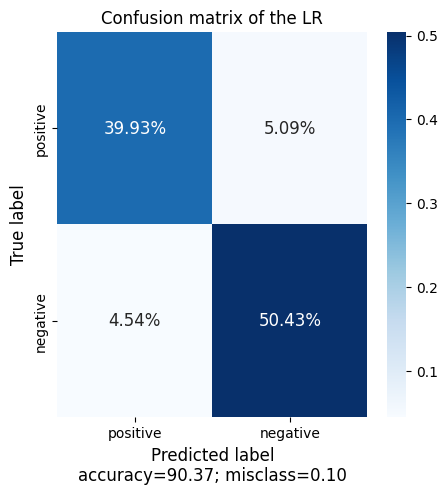

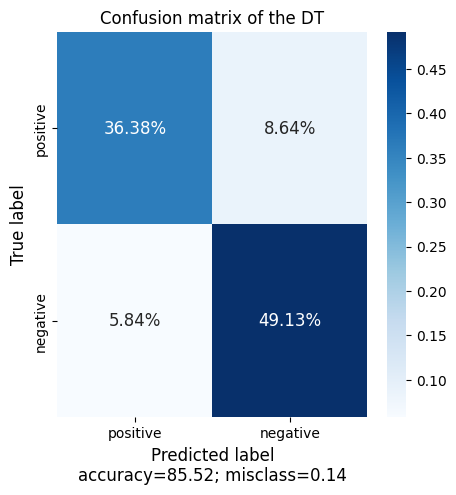

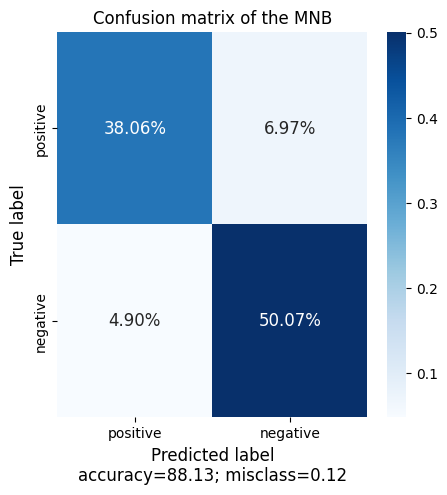

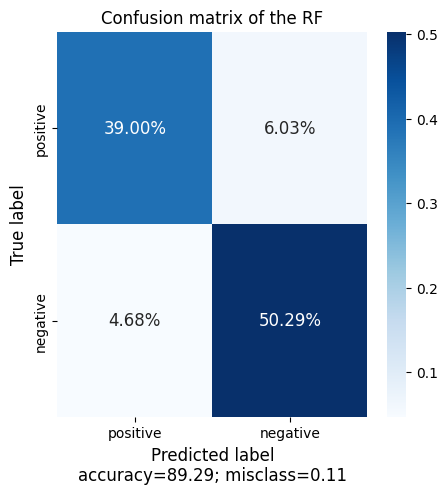

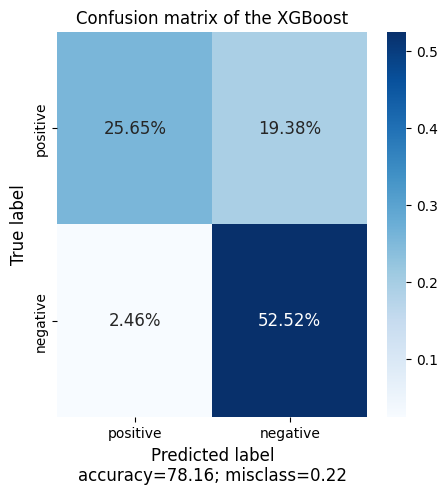

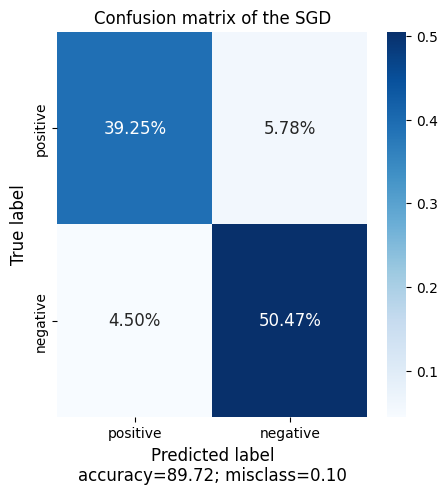

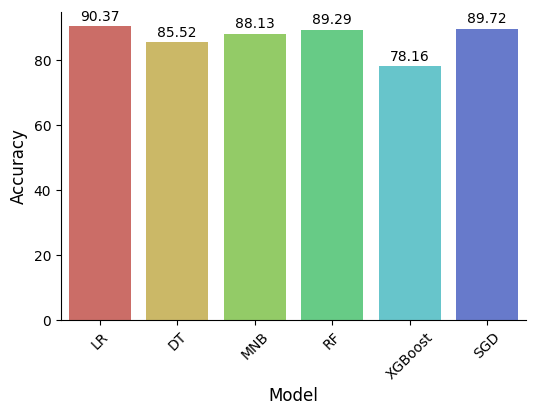

In [ ]:
print("Performance analysis on Tf-IDF vectorized data:")
testing_various_clf(Xtrain_tfidf,Xtest_tfidf,ytrain,ytest)

In [ ]:
print(SGDClassifier().fit(Xtrain_tfidf,ytrain).predict(tfidf_vect.transform(['A good Article'])))

[1]


In [ ]:
print(LogisticRegression().fit(Xtrain_count,ytrain).predict(count_vect.transform(['I did not like this book at all, I gave this book away'])))

[0]
